# Data binner
#### For FERMI data from Oct/Nov 2017 at DiProI beamline

## Info

This script works on the HDF5 files created by the Data collector (16_data_collection.ipynb) that end on '_col.h5' and are located in the 'combined' folder of each run.

The script has two main functionailities:
1. Apply filters to the data on a shot-to-shot basis with respect to e.g. incident intensity, photon energy bandwidth, ...
2. Bin the data along incident phton energy and pump-probe delay. For the incident photon energy binnig is performed based on the actual central photon energy of each shot.

Uses:
- /src/data_tools_v2.py
- /src/fit_tools.py


-----------------------
Created by Simon Schreck (simon.schreck@fysik.su.se) in Dec 2017 - Jan 2018 - with some parts beeing courtousy of Fivos Perakis.

Last updated: April 2018, by Simon Schreck (simon.schreck@fysik.su.se)

# Initialization
#### Load packages and functions

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import sys
import time
import scipy.stats
import os.path
from importlib import reload

sys.path.insert(0, '../src/')

import data_tools_v2
reload(data_tools_v2)

import fit_tools
reload(fit_tools)

#from data_tools_v2 import * as dt
import data_tools_v2 as dt
from fit_tools import *

# Ignore Runtime Warnings for divide and invalid values
np.seterr(divide='ignore', invalid='ignore')

##########################################
### DEFINE WHERE FIGURES ARE DISPLAYED ###
##########################################
# After changing this the kernel needs to be restarted
# Plot figures in in external windows (may need to set up your python environment properly for this to work)
#%matplotlib qt
# Plot figures inline in notebook
%matplotlib inline

# Define Paramters

In [6]:
#######################
### XAS DATA SOURCE ###
#######################
# Define which data are used for the XAS intensity
# Possible values:
# 'xas_img_int'    - Integrated intensity of the XAS image as calculated in data collection
# 'xas_daq_int'    - Integrated intensity of the XAS image as saved by DiProI DAQ
# 'xas_img_blobs'  - Number of blobs in XAS image (DO NOT USE (YET)

# 'xes_img_int'    - Integrated intensity of the XES image as calculated in data collection
# 'xes_daq_int'    - Integrated intensity of the XES image as saved by DiProI DAQ
# 'xes_img_blobs'  - Number of blobs in XES image (DO NOT USE (YET)

XAS_source = 'xas_img_int'

#########################
### SHOW HISTOGRAMS ? ###
#########################
show_histograms = True
# Number of bins
n_bin_i0      = 40
n_bin_centers = 40
n_bin_widths  = 40
n_bin_xas     = 40


#######################
### FILTER SETTINGS ###
#######################

# Incident intensity
filter_i0  = True 
i0_low_thr = 5e4
i0_hi_thr  = np.inf

# Incident photon energy bandwidth
filter_width  = True
width_low_thr = 0
width_hi_thr  = 0.8

# Incident photon energy position
filter_center  = False
center_low_thr = -np.inf
center_hi_thr  =  np.inf

# XAS intensity
filter_xas  = True
xas_low_thr = 1000
xas_hi_thr  = np.inf

# Mass spec count rate
filter_ms     = False
ms_low_thr    = 0
ms_hi_thr     = np.inf

##########################
### BINNING PARAMETERS ###
##########################

###### Incident photon energy ######
E_bin_type  = 'auto' # 'auto' or 'manual'
# If E_bin_type is 'auto' use:
E_bin_width = 0.1
# If E_bin_type is 'manual' use:
E_bin_edges_man = np.array([281.6, 282.0, 282.4, 282.8, 283.2, 283.6, 284.0, 284.4, 284.8, 285.2, 285.6, 286.0, 286.4])
E_bin_edges_man = np.array([280, 290.0])


######### Delay #####################
delay_bin_type   = 'auto' # 'auto' or 'manual'
# If delay_bin_type is 'auto' the delay values that were set during data aquisition are used as bin centers

# If delay_bin_type is 'manual' define unit and bin EDGES (!!!) here:
delay_bin_unit   = 'ps'     # 'mm' or 'ps'
delays_edges_man = np.array([-1, 0, 0.5, 1.0, 1.5, 5, 15, 310])


#################
### TIME ZERO ###
#################
def getTimeZero(runs, run_type, bt) :
    
    if bt == 2 :
        if (runs[0] in np.arange(0, 23+1)) and (run_type == 'XAS') :
            TimeZero = 141.654
        elif (runs[0] in [27, 28, 29]) and (run_type == 'XAS') :
            TimeZero = 141.530
        elif (runs[0] in [13, 14, 15, 16]) and (run_type == 'XES') :
            TimeZero = 141.530
        else :
            TimeZero = 141.654
    if bt == 1 :
        TimeZero = 136.376

    return TimeZero

#################
### XES STUFF ###
#################

# Should the XES spectra be binned? True/False
bin_xes_specs = True

# XES emission energy rebinning (1 pixel ~ 60 meV) 
xes_rebinning = 5 # 5 --> ~300 meV emission energy steps

# Provide filenames of dispersion of XES detector 
def getDisp(BT) :
    if BT == 1 :
        xes_disp = 'XAS021_disp.h5'
    elif BT == 2 :
        xes_disp = 'XAS035_disp.h5'
    else :
        raise NameError('BT mus be 1 or 2')
    return xes_disp

##############
### UNUSED ###
##############
bin_xes_blobs = False # DO NOT CHANGE THIS!!! 
disp_pixels   = 1625  # DO NOT CHANGE THIS!!! 
# BT 2
#xes_curv_file = 'XES001_NoPump_curv.h5'
# BT 1
xes_curv_file = 'XAS002_curv.h5'


# Do the Data Binning

Start binning runs:
[14, 18, 19, 20]

---Messages, Run 14:

---Messages, Run 18:

---Messages, Run 19:

---Messages, Run 20:

---Filtering...
... on I0 (5.0e+04, inf)
... on FEL bandwidth (0.00, 0.80)
... on XAS intensity (1000.00, inf)
Total number of ALL shots: 111420
Filtered out 6.30 percent of all the shots
Total number of GOOD shots: 104400


Delay bin edges and centers in mm:
[141.5145 141.5515 141.589  141.6265 141.6635 141.701  141.7385 141.776
 141.8135 141.851  141.8885 141.926  142.17   142.7695 143.894  146.8925
 151.3895]
[141.533 141.57  141.608 141.645 141.682 141.72  141.757 141.795 141.832
 141.87  141.907 141.945 142.395 143.144 144.644 149.141]
Delay bin edges and centers in ps:
[-9.30643826e-01 -6.83806395e-01 -4.33633324e-01 -1.83460252e-01
  6.33771781e-02  3.13550249e-01  5.63723321e-01  8.13896392e-01
  1.06406946e+00  1.31424254e+00  1.56441561e+00  1.81458868e+00
  3.44238146e+00  7.44181496e+00  1.49436715e+01  3.49475103e+01
  6.49482650e+01]
[-0.80722511 -

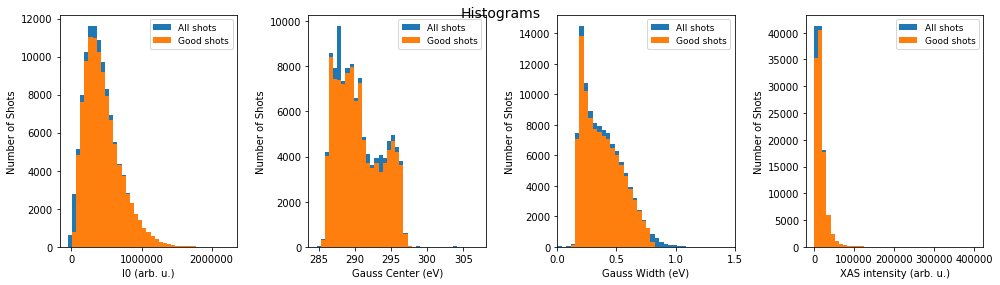

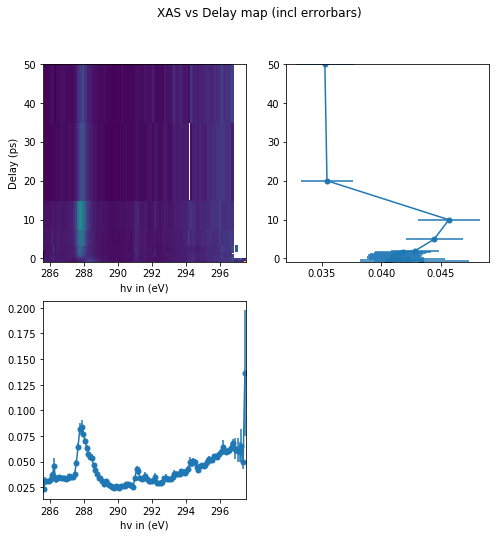

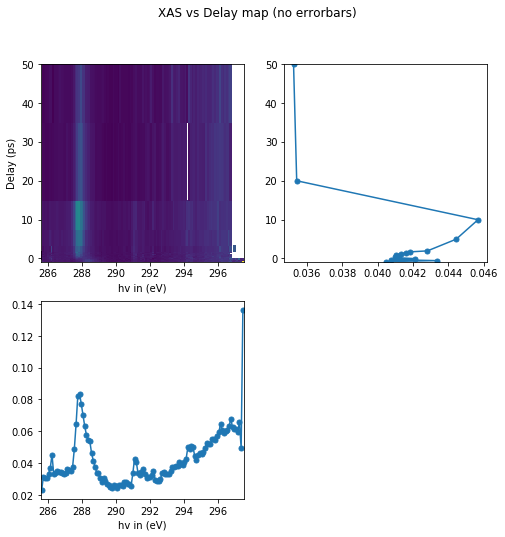

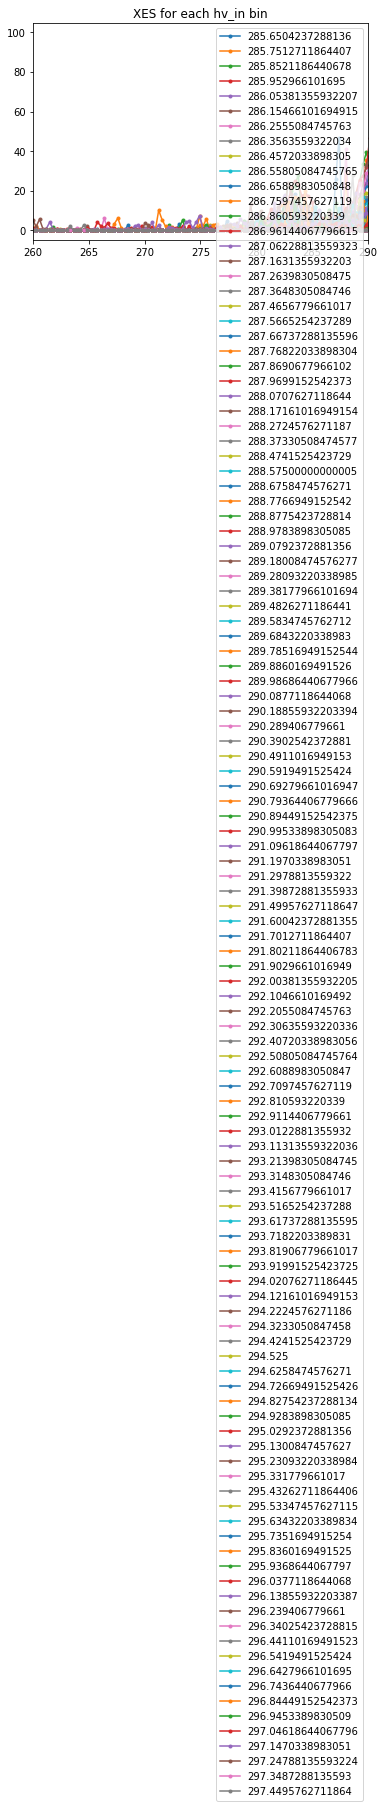

In [ ]:
# Reload data and fit tools
import data_tools_v2
reload(data_tools_v2)

import fit_tools
reload(fit_tools)

import data_tools_v2 as dt
from fit_tools import *

### --- START OF DEFINITION WHICH DATA TO BIN --- ###

##############################
### DEFINE THE RUN(S) ########
##############################

runs = [14,18,19,20]

run_type = 'XAS' # 'XAS' or 'XES'

##############################
### DEFINE THE BEAMTIME ######
##############################
BT = 2 # 1: 1st beamtime, 2: 2nd beamtime

##############################
### DEFINE THE DATA PATH #####
##############################
if(BT==1):
    data_path = 'D:/FERMI 2017 1/'
else:
    data_path = 'D:/FERMI 2017 2/'

### --- END OF DEFINITION WHICH DATA TO BIN --- ###


### --- START OF MAIN SCRIPT --- ###

# Check that data path exists
if not os.path.exists(data_path) :
    raise NameError('Check data_path! It does not exist!')

# Check that all runs exist
i = 0
while i < len(runs) :
    # Create the path to the run folder
    run_path = dt.do_runpath(runs[i], run_type, BT, data_path)
    
    if not os.path.exists(run_path) :
        print('Run %d does not exist! Skipping this run!'%runs[i])
        runs = np.delete(runs, i)
    else :
        i = i + 1
        
print('Start binning runs:')
print(runs)

# Get TimeZero
TimeZero = getTimeZero(runs, run_type, BT)

# Start timer
t = time.time()

# Reset some boleans
ms_missing = xes_missing = xes_spec_missing = False

# Define empty arrays to collect data in
bunch_id_all         = []
xas_int_all          = []
xas_tfy_all          = []
xas_tfy_blobsnum_all = []
xes_blobs_x_all      = []
xes_blobs_y_all      = []
xes_blobsnum_all     = []
xes_int_all          = []
xes_spec_all         = []
delay_pos_all        = []
laser_int_all        = []
ms_tof_all           = []
ms_counts_all        = []

i0_all               = []
Gauss_amps_all       = []
Gauss_centers_all    = []
Gauss_widths_all     = []

# Loop over runs to load the data
for run in runs :
    # Create the path to the RUN folder
    run_path = dt.do_runpath(run, run_type, BT, data_path)
    print('\n---Messages, Run %d:'%run)
    
    # Path to data in this folder
    load_path = run_path+'/combined/'
    
    # Get file names of 'collected' files
    tmp,file_names = dt.discover_files(load_path)
    
    ###########################
    ### CHECK IF DATA EXIST ###
    ###########################    
    
    
    
    fh5_check = h5py.File(load_path+file_names[0], 'r')
    
    if not '/MASSSPEC/counts' in fh5_check :
        if filter_ms :
            print('Mass Spec data are missing for run %d.'%run)
            print('Turning Mass Spec filtering OFF!')
        ms_missing = True
    
    if not '/XES/xes_blobsnum' in fh5_check:
    #    print('XES blobs are missing for run %d.'%run)
    #    print('Turning XES filtering and binning OFF!')
        xes_missing = True
        
    if not '/XES/xes_spec' in fh5_check:
        xes_spec_missing = True
        
    fh5_check.close()
        
    ########################
    ### LOAD THE DATA ######
    ########################
    # Loop over collected files
    for j in range(len(file_names)):
        
        fh5 = h5py.File(load_path+file_names[j], 'r')
        
        #print(file_names[j])
        # Bunch ID
        bunch_id = fh5['/bunch_id'].value
        bunch_id_all.extend(bunch_id)
        
        if XAS_source == 'xas_img_int' :
            # Use integrated image intensity
            xas_int = fh5['/XAS/xas_tfy'].value
            xas_int_all.extend(xas_int)
        elif XAS_source == 'xas_img_blobs' :
            # Use number of blobs in image
            xas_int = fh5['/XAS/xas_tfy_blobsnum'].value
            xas_int_all.extend(xas_int)
        elif XAS_source == 'xas_daq_int' :
            # Use integrated intensity provided by daq
            xas_int = fh5['/XAS/xas_int'].value
            xas_int_all.extend(xas_int)
        elif XAS_source == 'xes_img_int' :
            # Use integrated image intensity
            xas_int = fh5['/XES/xes_pfy'].value
            xas_int_all.extend(xas_int)
        elif XAS_source == 'xes_img_blobs' :
            # Use number of blobs in image
            xas_int = fh5['/XES/xes_blobsnum'].value
            xas_int_all.extend(xas_int)
        elif XAS_source == 'xes_daq_int' :
            # Use integrated intensity provided by daq
            xas_int = fh5['/XES/xes_int'].value
            xas_int_all.extend(xas_int)            
        else :
            raise NameError('XAS_source %s is not a valid source!'%XAS_source)

        # Delay
        delay_pos = fh5['/LASER/delay_pos'].value
        delay_pos_all.extend(delay_pos)
        
        # I0
        i0 = fh5['/FEL/i0'].value
        i0_all.extend(i0)
        
        # Gauss amps
        Gauss_amps = fh5['/FEL/Gauss_amps'].value
        Gauss_amps_all.extend(Gauss_amps)
        
        # Gauss centers
        Gauss_centers = fh5['/FEL/Gauss_centers'].value
        Gauss_centers_all.extend(Gauss_centers)
        
        # Gauss widths
        Gauss_widths = fh5['/FEL/Gauss_widths'].value
        Gauss_widths_all.extend(Gauss_widths)
        
        # MS counts
        if not ms_missing :
            ms_counts = fh5['/MASSSPEC/counts'].value
            ms_counts_all.extend(ms_counts)
            
        # XES
        if not xes_missing and bin_xes_blobs:
            xes_blobsnum = fh5['/XES/xes_blobsnum'].value
            xes_blobsnum_all.extend(xes_blobsnum)
            xes_blobs_x = fh5['/XES/xes_blobs_x'].value
            xes_blobs_x_all.extend(xes_blobs_x)
            xes_blobs_y = fh5['/XES/xes_blobs_y'].value
            xes_blobs_y_all.extend(xes_blobs_y)
            
        if not xes_spec_missing :
            xes_spec = fh5['/XES/xes_spec'].value
            xes_spec_all.extend(xes_spec)
            
bunch_id_all         = np.array(bunch_id_all)
xas_int_all          = np.array(xas_int_all)
delay_pos_all        = np.array(delay_pos_all)
i0_all               = np.array(i0_all)
Gauss_amps_all       = np.array(Gauss_amps_all)
Gauss_centers_all    = np.array(Gauss_centers_all)
Gauss_widths_all     = np.array(Gauss_widths_all)
ms_counts_all        = np.array(ms_counts_all)
xes_blobsnum_all     = np.array(xes_blobsnum_all)
xes_blobs_x_all      = np.array(xes_blobs_x_all)
xes_blobs_y_all      = np.array(xes_blobs_y_all)
xes_spec_all         = np.array(xes_spec_all)

xes_spec_length = len(xes_spec_all)/len(bunch_id_all)

# Take out all shots wehere FEL spectrum fit failed, i.e. where fit parameters are NaN (to not have runtime warning later)
nan_mask     = ~np.isnan(Gauss_widths_all)
if not xes_missing and bin_xes_blobs:
    nan_mask_xes = np.repeat(nan_mask, xes_blobsnum_all)
if not xes_spec_missing :
    nan_mask_xes_spec = np.repeat(nan_mask, xes_spec_length)
    
bunch_id_all         = bunch_id_all[nan_mask]
xas_int_all          = xas_int_all[nan_mask]
delay_pos_all        = delay_pos_all[nan_mask]
i0_all               = i0_all[nan_mask]
Gauss_amps_all       = Gauss_amps_all[nan_mask]
Gauss_centers_all    = Gauss_centers_all[nan_mask]
Gauss_widths_all     = Gauss_widths_all[nan_mask]
if not ms_missing :
    ms_counts_all        = ms_counts_all[nan_mask]
if not xes_missing and bin_xes_blobs:
    xes_blobsnum_all     = xes_blobsnum_all[nan_mask]
    xes_blobs_x_all      = xes_blobs_x_all[nan_mask_xes]
    xes_blobs_y_all      = xes_blobs_y_all[nan_mask_xes]
if not xes_spec_missing and bin_xes_specs:
    xes_spec_all         = xes_spec_all[nan_mask_xes_spec]
    
########################
### FILTER THE DATA ####
########################
print('\n---Filtering...')
# Build the filter matrix
filter_matrix = []

filter_matrix.append(delay_pos_all!=0)

# Filter on I0
if filter_i0 :
    print('... on I0 (%2.1e, %2.1e)'%(i0_low_thr, i0_hi_thr))
    filter_matrix.append(i0_all>=i0_low_thr)
    filter_matrix.append(i0_all<=i0_hi_thr)

# Filter on FEL bandwith
if filter_width :
    print('... on FEL bandwidth (%3.2f, %3.2f)' %(width_low_thr, width_hi_thr))
    filter_matrix.append(Gauss_widths_all>=width_low_thr)
    filter_matrix.append(Gauss_widths_all<=width_hi_thr)
    
# Filter on FEL center energy
if filter_center :
    print('... on FEL center energy (%3.2f, %3.2f)' %(center_low_thr, center_hi_thr))
    filter_matrix.append(Gauss_centers_all>=center_low_thr)
    filter_matrix.append(Gauss_centers_all<=center_hi_thr)
    
# Filter on XAS intensity
if filter_xas :
    print('... on XAS intensity (%3.2f, %3.2f)' %(xas_low_thr, xas_hi_thr))
    filter_matrix.append(xas_int_all>=xas_low_thr)
    filter_matrix.append(xas_int_all<=xas_hi_thr)

# Filter on MS counts
if filter_ms and not ms_missing:
    print('... on MASS SPEC counts')
    filter_matrix.append(ms_counts_all>=ms_low_thr)
    filter_matrix.append(ms_counts_all<=ms_hi_thr)
    
good_shots_mask = np.all(filter_matrix, axis=0)
if not xes_missing and bin_xes_blobs:
    good_shots_mask_xes = np.repeat(good_shots_mask, xes_blobsnum_all)
if not xes_spec_missing and bin_xes_specs:
    good_shots_mask_xes_spec = np.repeat(good_shots_mask, xes_spec_length)

# Apply the filter
bunch_id_good         = bunch_id_all[good_shots_mask]
xas_int_good          = xas_int_all[good_shots_mask]
delay_pos_good        = delay_pos_all[good_shots_mask]
i0_good               = i0_all[good_shots_mask]
Gauss_amps_good       = Gauss_amps_all[good_shots_mask]
Gauss_centers_good    = Gauss_centers_all[good_shots_mask]
Gauss_widths_good     = Gauss_widths_all[good_shots_mask]
if not ms_missing :
    ms_counts_good        = ms_counts_all[good_shots_mask]
if not xes_missing and bin_xes_blobs:
    xes_blobsnum_good     = xes_blobsnum_all[good_shots_mask]
    xes_blobs_x_good      = xes_blobs_x_all[good_shots_mask_xes]
    xes_blobs_y_good      = xes_blobs_y_all[good_shots_mask_xes]
if not xes_spec_missing and bin_xes_specs:
    xes_spec_good         = xes_spec_all[good_shots_mask_xes_spec]

print('Total number of ALL shots: %d' %(len(bunch_id_all)))
print('Filtered out %3.2f percent of all the shots' %(100*(len(bunch_id_all)-len(bunch_id_good))/len(bunch_id_all)))
print('Total number of GOOD shots: %d' %(len(bunch_id_good)))

########################
### Plot Histrograms ###
########################
if show_histograms :
    plt.figure(figsize = [14, 4])
    
    plt.suptitle('Histograms', fontsize = 14)
    
    # I0
    plt.subplot(141)
    i0_bins = np.arange(np.min(i0_all), np.max(i0_all), (np.max(i0_all) - np.min(i0_all)) / n_bin_i0)
    plt.hist(i0_all, bins = i0_bins, label = 'All shots') 
    plt.hist(i0_good, bins = i0_bins, label = 'Good shots')
    plt.ylabel('Number of Shots')
    plt.xlabel('I0 (arb. u.)')
    #plt.title('Incident intensity I0')
    plt.legend(loc = 0, fontsize = 9)
    
    # Gauss_centers
    plt.subplot(142)
    Gauss_centers_bins = np.arange(np.min(Gauss_centers_all), np.max(Gauss_centers_all), (np.max(Gauss_centers_all) - np.min(Gauss_centers_all)) / n_bin_centers)
    plt.hist(Gauss_centers_all, bins = Gauss_centers_bins, label = 'All shots') 
    plt.hist(Gauss_centers_good, bins = Gauss_centers_bins, label = 'Good shots')
    plt.ylabel('Number of Shots')
    plt.xlabel('Gauss Center (eV)')
    #plt.title('Incident photon energy Gauss_centers')
    plt.legend(loc = 0, fontsize = 9)
    
    # Gauss_widths
    plt.subplot(143)
    #Gauss_widths_bins = np.arange(np.min(Gauss_widths_all), np.max(Gauss_widths_all), (np.max(Gauss_widths_all) - np.min(Gauss_widths_all)) / n_bin_widths)
    Gauss_widths_bins = np.arange(0, 1.5, 1.5/n_bin_widths)
    plt.hist(Gauss_widths_all, bins = Gauss_widths_bins, label = 'All shots') 
    plt.hist(Gauss_widths_good, bins = Gauss_widths_bins, label = 'Good shots')
    plt.ylabel('Number of Shots')
    plt.xlabel('Gauss Width (eV)')
    #plt.title('Incident bandwidth Gauss_widths')
    plt.xlim([0, 1.5])
    plt.legend(loc = 0, fontsize = 9)
    
    # xas_int
    plt.subplot(144)
    xas_int_bins = np.arange(np.min(xas_int_all), np.max(xas_int_all), (np.max(xas_int_all) - np.min(xas_int_all)) / n_bin_xas)
    plt.hist(xas_int_all, bins = xas_int_bins, label = 'All shots') 
    plt.hist(xas_int_good, bins = xas_int_bins, label = 'Good shots')
    plt.ylabel('Number of Shots')
    plt.xlabel('XAS intensity (arb. u.)')
    #plt.title('XAS intensity')
    plt.legend(loc = 0, fontsize = 9)
    
    plt.tight_layout()

#####################
### BIN THE DATA ####
#####################
# Create DELAY axis and DELAY bin edges
if delay_bin_type == 'auto' :
    delays_mm, n_shots_delay = np.unique(delay_pos_good, return_counts=True)

    if not len(delays_mm) == 1 :
        delays_mm_edges = (delays_mm[1:] + delays_mm[:-1]) / 2
        delays_mm_edges = np.insert(delays_mm_edges, 0, delays_mm[0] - 0.5*(delays_mm[1]-delays_mm[0]))
        delays_mm_edges = np.append(delays_mm_edges, delays_mm[-1] + 0.5*(delays_mm[-1]-delays_mm[-2])) 
    else :
        delays_mm_edges = np.array([delays_mm[0] - 200, delays_mm[0] + 200])

    delays_fs       = dt.mm2fs(delays_mm - TimeZero)
    delays_fs_edges = dt.mm2fs(delays_mm_edges - TimeZero)

elif delay_bin_type == 'manual' :
    if delay_bin_unit == 'mm' :
        delays_mm_edges = delays_edges_man
    elif delay_bin_unit == 'ps' :
        delays_mm_edges = dt.fs2mm(delays_edges_man*1e3) + TimeZero
        
    delays_mm_edges = np.array(delays_mm_edges)
        
    delays_mm       = (delays_mm_edges[1:] + delays_mm_edges[:-1]) / 2
    delays_fs       = dt.mm2fs(delays_mm - TimeZero)
    delays_fs_edges = dt.mm2fs(delays_mm_edges - TimeZero)


# Create PHOTON ENERGY axis and PHOTON ENERGY bin edges
if E_bin_type == 'auto' :
    E_bin_min = np.floor(np.min(Gauss_centers_good)/E_bin_width)*E_bin_width
    E_bin_max = np.ceil(np.max(Gauss_centers_good)/E_bin_width)*E_bin_width

    bin_num = (E_bin_max - E_bin_min) / E_bin_width

    E_bin_edges   = np.linspace(E_bin_min, E_bin_max, num = np.int(bin_num)+1)
elif E_bin_type == 'manual' :
    E_bin_edges = np.array(E_bin_edges_man, dtype=float)
else :
    raise NameError('E_bin_type must be auto or manual')

E_bin_centers = (E_bin_edges[1:] + E_bin_edges[:-1]) / 2

# Print(delay and hv bin edges)
print('\n')
print('Delay bin edges and centers in mm:')
print(delays_mm_edges)
print(delays_mm)
print('Delay bin edges and centers in ps:')
print(delays_fs_edges*1e-3)
print(delays_fs*1e-3)
print('Photon energy bin edges and centers in eV')
print(E_bin_edges)
print(E_bin_centers)
print('\n')


### XAS BINNING ###
# Make 2d (delay_mm vs hv_inc) histograms for TFY intensity, I0, num of shots and XAS = TFY / I0
hist_tfy,   xed, yed = np.histogram2d(delay_pos_good, Gauss_centers_good, bins=[delays_mm_edges, E_bin_edges], weights = xas_int_good)
hist_i0,    xed, yed = np.histogram2d(delay_pos_good, Gauss_centers_good, bins=[delays_mm_edges, E_bin_edges], weights = i0_good)
hist_shots, xed, yed = np.histogram2d(delay_pos_good, Gauss_centers_good, bins=[delays_mm_edges, E_bin_edges])
hist_xas,   xed, yed = np.histogram2d(delay_pos_good, Gauss_centers_good, bins=[delays_mm_edges, E_bin_edges], weights = xas_int_good/i0_good)

# Get the standard deviation for each bin in the above 2d histograms
std_tfy_a = scipy.stats.binned_statistic_2d(delay_pos_good, Gauss_centers_good, xas_int_good,         np.std, bins=[delays_mm_edges, E_bin_edges])
std_i0_a  = scipy.stats.binned_statistic_2d(delay_pos_good, Gauss_centers_good, i0_good,              np.std, bins=[delays_mm_edges, E_bin_edges])
std_xas_a = scipy.stats.binned_statistic_2d(delay_pos_good, Gauss_centers_good, xas_int_good/i0_good, np.std, bins=[delays_mm_edges, E_bin_edges])

std_tfy   = std_tfy_a.statistic
std_i0    = std_i0_a.statistic
std_xas   = std_xas_a.statistic

# Calculate the standard error for each bin in the above 2d histograms
hist_tfy_err = std_tfy / np.sqrt(hist_shots)
hist_i0_err  = std_i0 / np.sqrt(hist_shots)
hist_xas_err = std_xas / np.sqrt(hist_shots)

# Normalize the 2d histograms by number of shots in each bin
XAS_2dmatrix   = hist_xas / hist_shots
TFY_2dmatrix   = hist_tfy / hist_shots
i0_2dmatrix    = hist_i0  / hist_shots

# Rename shots histogram and error histograms (just for consistency)
Shots_2dmatrix = hist_shots

XAS_2dmatrix_err   = hist_xas_err
TFY_2dmatrix_err   = hist_tfy_err
i0_2dmatrix_err    = hist_i0_err

# Calculate XAS intensity as TFY divided by I0 after binning (v2)
XAS_2dmatrix_v2   = hist_tfy/hist_i0

# Get projections onto hv and delay axis
XAS_hv_all     = np.nansum(XAS_2dmatrix, axis = 0) / np.sum(~np.isnan(XAS_2dmatrix), axis = 0)
XAS_delay_all  = np.nansum(XAS_2dmatrix, axis = 1) / np.sum(~np.isnan(XAS_2dmatrix), axis = 1)
    
XAS_hv_all_err    = np.nansum(XAS_2dmatrix_err, axis = 0) / np.sum(~np.isnan(XAS_2dmatrix_err), axis = 0)
XAS_delay_all_err = np.nansum(XAS_2dmatrix_err, axis = 1) / np.sum(~np.isnan(XAS_2dmatrix_err), axis = 1)


#plt.figure()
#plt.plot(E_bin_centers, XAS_hv_all, label = 'normal')
#plt.plot(E_bin_centers, XAS_hv_all_nan, label = 'nan norm')
#plt.legend(loc=0)

# Plot the binned data
"""
plt.figure()
plt.plot(E_bin_centers, I_XAS_bin_norm, label = '1d binnig')
plt.plot(E_bin_centers, XAS_hv_all, label = '2d binnig')
plt.legend(loc=0)
"""
### PLOT INCL ERRORBARS ###
plt.figure(figsize = [8, 8])
plt.subplot(221)
X,Y = np.meshgrid(E_bin_edges, delays_fs_edges*1e-3)
plt.pcolor(X, Y, XAS_2dmatrix)
plt.xlabel('hv in (eV)')
plt.ylabel('Delay (ps)')
plt.ylim([np.min(delays_fs*1e-3), np.max(delays_fs*1e-3)])

plt.subplot(222)
plt.errorbar(XAS_delay_all, delays_fs*1e-3, xerr = XAS_delay_all_err, markersize = 5, marker = 'o', ls = '-')
plt.ylim([np.min(delays_fs*1e-3), np.max(delays_fs*1e-3)])
#plt.ylabel('Delay stage pos (mm)')

plt.subplot(223)
plt.errorbar(E_bin_centers, XAS_hv_all, yerr = XAS_hv_all_err, markersize = 5, marker = 'o', ls = '-')
plt.xlim([np.min(E_bin_edges), np.max(E_bin_edges)])
plt.xlabel('hv in (eV)')

plt.suptitle('XAS vs Delay map (incl errorbars)')

### PLOT WITHOUT ERRORBARS ###
plt.figure(figsize = [8, 8])
plt.subplot(221)
X,Y = np.meshgrid(E_bin_edges, delays_fs_edges*1e-3)
plt.pcolor(X, Y, XAS_2dmatrix)
plt.xlabel('hv in (eV)')
plt.ylabel('Delay (ps)')
plt.ylim([np.min(delays_fs*1e-3), np.max(delays_fs*1e-3)])

plt.subplot(222)
plt.plot(XAS_delay_all, delays_fs*1e-3, markersize = 5, marker = 'o', ls = '-')
plt.ylim([np.min(delays_fs*1e-3), np.max(delays_fs*1e-3)])
#plt.ylabel('Delay stage pos (mm)')

plt.subplot(223)
plt.plot(E_bin_centers, XAS_hv_all, markersize = 5, marker = 'o', ls = '-')
plt.xlim([np.min(E_bin_edges), np.max(E_bin_edges)])
plt.xlabel('hv in (eV)')

plt.suptitle('XAS vs Delay map (no errorbars)')

### XES SPECTRA BINNING ###
if not xes_spec_missing and bin_xes_specs:
    
    # Rebin the emission energy axis (still in pixels here)
    xes_spec_length_rebin = int(np.floor(xes_spec_length/xes_rebinning))
    end = int(xes_rebinning * xes_spec_length_rebin)
    xes_x       = np.arange(xes_spec_length)
    xes_x_rebin = np.sum(np.reshape(xes_x[:end], (-1, xes_rebinning)), axis = 1) / xes_rebinning

    # Create matrix to bin xes spectra into
    xes_spec_3dmatrix = np.zeros((len(delays_mm), len(E_bin_centers), xes_spec_length_rebin))
    
    # Split up the complete xes spectra array into single spectra
    xes_spec_good_split = np.split(xes_spec_good, len(bunch_id_good))
    
    # Get bin inices for delay and photon energy axis
    delay_pos_good_dig     = np.digitize(delay_pos_good, delays_mm_edges, right = True) - 1
    Gauss_centers_good_dig = np.digitize(Gauss_centers_good, E_bin_edges, right = True) - 1
    
    # Loop over shots
    for i in np.arange(len(xes_spec_good_split)) :
        # Rebin xes spectra intensity
        xes_spec_rebin = np.sum(np.reshape(xes_spec_good_split[i][:end], (-1, xes_rebinning)), axis = 1) / xes_rebinning
        xes_spec_rebin = xes_spec_rebin / hist_shots[delay_pos_good_dig[i], Gauss_centers_good_dig[i]]
        # Sum up the spectra for each delay and photon energy bin
        xes_spec_3dmatrix[delay_pos_good_dig[i], Gauss_centers_good_dig[i], :] = xes_spec_3dmatrix[delay_pos_good_dig[i], Gauss_centers_good_dig[i], :] + xes_spec_rebin
        
    # Tranform pixels into emission energy eV
    xes_disp_file = getDisp(BT)
    #disp_file = data_path + 'Dispersion/' + xes_disp_file
    disp_file = '../src/' + xes_disp_file
    h5_disp = h5py.File(disp_file, 'r')
    p_disp = h5_disp['p_disp'].value
    h5_disp.close()
    xes_x_ev = dt.pix2eV(xes_x_rebin, p_disp)
    
    # Get the XES spectrum for all delays and all photon energies
    xes_spec_sum_all = np.sum(np.sum(xes_spec_3dmatrix, axis = 0), axis = 0)
    # Sum up all photon energies
    xes_specs_delay = np.sum(xes_spec_3dmatrix, axis = 1)
    # Sum up all delays
    xes_specs_hv = np.sum(xes_spec_3dmatrix, axis = 0)
    
    plt.figure()
    for i in np.arange(len(E_bin_centers)) :
        plt.plot(xes_x_ev, xes_specs_hv[i], '-o', ms = 3, label = E_bin_centers[i])
    plt.legend(loc = 0)
    plt.title('XES for each hv_in bin')
    plt.xlim([260, 290])

    
### XES blobs BINNING ### (Under construction.... / Not Used)
if not xes_missing and bin_xes_blobs:
    # Create emission energy axis (still in pixels) and bin edges    
    XES_bin_edges   = np.arange(0, disp_pixels, xes_rebinning)
    XES_bin_centers = (XES_bin_edges[1:] + XES_bin_edges[:-1]) / 2
    # Curvature correction
    curv_file = data_path + 'Curvatures/' + xes_curv_file
    h5_curve = h5py.File(curv_file, 'r')
    p_curv = h5_curve['popt'].value
    h5_curve.close()
    
    p1 = p_curv[0]
    p2 = p_curv[1]
    p3 = p_curv[2]
    
    xes_blobs_x_good_corr = np.zeros(np.shape(xes_blobs_x_good))
    
    for i in np.arange(len(xes_blobs_x_good)) :
        shift = poly2(xes_blobs_y_good[i], p1, p2, p3) - p3
        xes_blobs_x_good_corr[i] = xes_blobs_x_good[i] - shift

    # 1. Repeat delay positions and hv_in according to number of XES blobs
    # 2. Transform the vectors (np.newaxis command) for later concatenation
    delay_pos_good_xes     = np.array(np.repeat(delay_pos_good, xes_blobsnum_good))[np.newaxis]
    Gauss_centers_good_xes = np.array(np.repeat(Gauss_centers_good, xes_blobsnum_good))[np.newaxis]
    xes_blobs_x_good       = np.array(xes_blobs_x_good_corr)[np.newaxis]
    
    # Concatenate delay positions, hv_in and XES blobs x-positions for 3d histogramming
    delay_hv_xes = np.concatenate((np.transpose(delay_pos_good_xes), np.transpose(Gauss_centers_good_xes), np.transpose(xes_blobs_x_good)), axis=1)

    # Do the 3d histogram
    # H is 3d dataset delay-hv_in_hv_emission: axis 0 = delay, axis 1 = hv inc, axis 2 = hv emission
    H, edges = np.histogramdd(delay_hv_xes, bins = (delays_mm_edges, E_bin_edges, XES_bin_edges))
    
    # Sum up all delays and all inc photon energies --> XES spectrum
    XES_all = np.sum(np.sum(H, axis = 0), axis = 0)
    # Sum up all inc photon energies --> XES spectrum
    XES_delays_all = np.sum(H, axis = 1)
    # Sum up all emission energies and all delays --> PFY XAS spectrum
    XAS_PFY_hv_all = np.sum(np.sum(H, axis = 2), axis = 0)
    # Sum up all emission energies and all incident energies --> PFY XAS delay trace
    XAS_PFY_delay_all = np.sum(np.sum(H, axis = 2), axis = 1)

#############################################
### SAVE THE DATA AND PARAMETERS/SETTINGS ###
#############################################
# If 'Binned' folder does not yet exist, create it
# if not os.path.exists(data_path+'Binned/') :
#    os.makedirs(data_path+'Binned/')
    
# Define the filename for saved data
run_s_str = '%03d'%(runs[0])
run_e_str = '%03d'%(runs[-1])
# save_file   = data_path+'Binned/'+run_type+'_'+run_s_str+'_'+run_e_str+'_bin.h5'
save_file = 'C:/Users/larue/OneDrive - Chapman University/Research/X-Ray Femtochemistry/Fermi 2017/Binned/BT'+str(BT)+'/'+run_type+'_'+run_s_str+'_'+run_e_str+'_bin.h5'            

# Open file (if exists), else create file
fh5 = h5py.File(save_file, 'a') 

# Runs
if 'runs' in fh5: del fh5['runs']
dataSet = fh5.create_dataset('runs', data = runs, dtype = np.int32)
# TimeZero
if 'TimeZero' in fh5: del fh5['TimeZero']
dataSet = fh5.create_dataset('TimeZero', data = TimeZero, dtype = np.float32)

# XAS source
if 'XAS_source' in fh5: del fh5['XAS_source']
dataSet = fh5.create_dataset('XAS_source', data = np.string_(XAS_source), dtype="S10")

### Filter Settings
# filter_i0
if 'FilterSettings/filter_i0' in fh5: del fh5['FilterSettings/filter_i0']
dataSet = fh5.create_dataset('FilterSettings/filter_i0', data = filter_i0, dtype = 'u1')
# i0_low_thr
if 'FilterSettings/i0_low_thr' in fh5: del fh5['FilterSettings/i0_low_thr']
dataSet = fh5.create_dataset('FilterSettings/i0_low_thr', data = i0_low_thr, dtype = np.float32)
# i0_hi_thr
if 'FilterSettings/i0_hi_thr' in fh5: del fh5['FilterSettings/i0_hi_thr']
dataSet = fh5.create_dataset('FilterSettings/i0_hi_thr', data = i0_hi_thr, dtype = np.float32)

# filter_width
if 'FilterSettings/filter_width' in fh5: del fh5['FilterSettings/filter_width']
dataSet = fh5.create_dataset('FilterSettings/filter_width', data = filter_width, dtype = 'u1')
# width_low_thr
if 'FilterSettings/width_low_thr' in fh5: del fh5['FilterSettings/width_low_thr']
dataSet = fh5.create_dataset('FilterSettings/width_low_thr', data = width_low_thr, dtype = np.float32)
# i0_hi_thr
if 'FilterSettings/width_hi_thr' in fh5: del fh5['FilterSettings/width_hi_thr']
dataSet = fh5.create_dataset('FilterSettings/width_hi_thr', data = width_hi_thr, dtype = np.float32)

# filter_ms
if 'FilterSettings/filter_ms' in fh5: del fh5['FilterSettings/filter_ms']
dataSet = fh5.create_dataset('FilterSettings/filter_ms', data = filter_ms, dtype = 'u1')
# ms_low_thr
if 'FilterSettings/ms_low_thr' in fh5: del fh5['FilterSettings/ms_low_thr']
dataSet = fh5.create_dataset('FilterSettings/ms_low_thr', data = ms_low_thr, dtype = np.float32)
# i0_hi_thr
if 'FilterSettings/ms_hi_thr' in fh5: del fh5['FilterSettings/ms_hi_thr']
dataSet = fh5.create_dataset('FilterSettings/ms_hi_thr', data = ms_hi_thr, dtype = np.float32)

### Bin Settings
# XAS E_bin_type
if 'BinSettings/E_bin_type' in fh5: del fh5['BinSettings/E_bin_type']
dataSet = fh5.create_dataset('BinSettings/E_bin_type', data = np.string_(E_bin_type), dtype="S10")
if E_bin_type == 'auto' :
    # E_bin_width
    if 'BinSettings/E_bin_width' in fh5: del fh5['BinSettings/E_bin_width']
    dataSet = fh5.create_dataset('BinSettings/E_bin_width', data = E_bin_width, dtype = np.float32)
if E_bin_type == 'manual' :
    # E_bin_edges_man
    if 'BinSettings/E_bin_edges_man' in fh5: del fh5['BinSettings/E_bin_edges_man']
    dataSet = fh5.create_dataset('BinSettings/E_bin_edges_man', data = E_bin_edges_man, dtype = np.float32)
    
# Delay Bintype
if 'BinSettings/delay_bin_type' in fh5: del fh5['BinSettings/delay_bin_type']
dataSet = fh5.create_dataset('BinSettings/delay_bin_type', data = np.string_(delay_bin_type), dtype="S10")
if delay_bin_type == 'manual' :
    # delay_bin_edges_unit
    if 'BinSettings/delay_bin_unit' in fh5: del fh5['BinSettings/delay_bin_unit']
    dataSet = fh5.create_dataset('BinSettings/delay_bin_unit', data = np.string_(delay_bin_unit), dtype="S10")
    # delay_bin_edges_man
    if 'BinSettings/delays_edges_man' in fh5: del fh5['BinSettings/delays_edges_man']
    dataSet = fh5.create_dataset('BinSettings/delays_edges_man', data = delays_edges_man, dtype = np.float32)
    
if not xes_spec_missing :
    # XES emissino energy axis rebinning
    if 'BinSettings/xes_rebinning' in fh5: del fh5['BinSettings/xes_rebinning']
    dataSet = fh5.create_dataset('BinSettings/xes_rebinning', data = xes_rebinning, dtype = np.int32)

### Binned Data
# Incident photon energy axis
if 'BinnedData/E_bin_centers' in fh5: del fh5['BinnedData/E_bin_centers']
dataSet = fh5.create_dataset('BinnedData/E_bin_centers', data = E_bin_centers, dtype = np.float32)
if 'BinnedData/E_bin_edges' in fh5: del fh5['BinnedData/E_bin_edges']
dataSet = fh5.create_dataset('BinnedData/E_bin_edges', data = E_bin_edges, dtype = np.float32)

# Delay axis in mm
if 'BinnedData/delays_mm' in fh5: del fh5['BinnedData/delays_mm']
dataSet = fh5.create_dataset('BinnedData/delays_mm', data = delays_mm, dtype = np.float32)
if 'BinnedData/delays_mm_edges' in fh5: del fh5['BinnedData/delays_mm_edges']
dataSet = fh5.create_dataset('BinnedData/delays_mm_edges', data = delays_mm_edges, dtype = np.float32)
# Delay axis in fs
if 'BinnedData/delays_fs' in fh5: del fh5['BinnedData/delays_fs']
dataSet = fh5.create_dataset('BinnedData/delays_fs', data = delays_fs, dtype = np.float32)
if 'BinnedData/delays_fs_edges' in fh5: del fh5['BinnedData/delays_fs_edges']
dataSet = fh5.create_dataset('BinnedData/delays_fs_edges', data = delays_fs_edges, dtype = np.float32)

# 2D data
# XAS intensity 2d matrix
if 'BinnedData/XAS_2dmatrix' in fh5: del fh5['BinnedData/XAS_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/XAS_2dmatrix', data = XAS_2dmatrix, dtype = np.float32)
# XAS intensity 2d matrix (v2 - calculated as hist_tfy/hist_i0)
if 'BinnedData/XAS_2dmatrix_v2' in fh5: del fh5['BinnedData/XAS_2dmatrix_v2']
dataSet = fh5.create_dataset('BinnedData/XAS_2dmatrix_v2', data = XAS_2dmatrix_v2, dtype = np.float32)
# Shots 2d matrix
if 'BinnedData/Shots_2dmatrix' in fh5: del fh5['BinnedData/Shots_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/Shots_2dmatrix', data = Shots_2dmatrix, dtype = np.float32)
# I0 2d matrix (I0 intensity per shot)
if 'BinnedData/i0_2dmatrix' in fh5: del fh5['BinnedData/i0_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/i0_2dmatrix', data = i0_2dmatrix, dtype = np.float32)
# TFY 2d matrix (XAS detector intensity per shot - not normalized by I0)
if 'BinnedData/TFY_2dmatrix' in fh5: del fh5['BinnedData/TFY_2dmatrix']
dataSet = fh5.create_dataset('BinnedData/TFY_2dmatrix', data = TFY_2dmatrix, dtype = np.float32)

# ERRORS 2D data
# XAS intensity 2d matrix
if 'BinnedData/XAS_2dmatrix_err' in fh5: del fh5['BinnedData/XAS_2dmatrix_err']
dataSet = fh5.create_dataset('BinnedData/XAS_2dmatrix_err', data = XAS_2dmatrix_err, dtype = np.float32)
# I0 2d matrix
if 'BinnedData/i0_2dmatrix_err' in fh5: del fh5['BinnedData/i0_2dmatrix_err']
dataSet = fh5.create_dataset('BinnedData/i0_2dmatrix_err', data = i0_2dmatrix_err, dtype = np.float32)
# TFY 2d matrix (XAS detector intensity - not normalized by I0 nor by number of shots)
if 'BinnedData/TFY_2dmatrix_err' in fh5: del fh5['BinnedData/TFY_2dmatrix_err']
dataSet = fh5.create_dataset('BinnedData/TFY_2dmatrix_err', data = TFY_2dmatrix_err, dtype = np.float32)

# PROJECTIONS
# XAS spectrum
if 'BinnedData/XAS_hv_all' in fh5: del fh5['BinnedData/XAS_hv_all']
dataSet = fh5.create_dataset('BinnedData/XAS_hv_all', data = XAS_hv_all, dtype = np.float32)
# Delay trace
if 'BinnedData/XAS_delay_all' in fh5: del fh5['BinnedData/XAS_delay_all']
dataSet = fh5.create_dataset('BinnedData/XAS_delay_all', data = XAS_delay_all, dtype = np.float32)

# ERRORS PROJECTIONS 
# XAS spectrum
if 'BinnedData/XAS_hv_all_err' in fh5: del fh5['BinnedData/XAS_hv_all_err']
dataSet = fh5.create_dataset('BinnedData/XAS_hv_all_err', data = XAS_hv_all_err, dtype = np.float32)
# Delay trace
if 'BinnedData/XAS_delay_all_err' in fh5: del fh5['BinnedData/XAS_delay_all_err']
dataSet = fh5.create_dataset('BinnedData/XAS_delay_all_err', data = XAS_delay_all_err, dtype = np.float32)

# XES BINNED DATA
if not xes_spec_missing and bin_xes_specs:
    # XES emission energy axis in pixels
    if 'BinnedData/xes_x_pix' in fh5: del fh5['BinnedData/xes_x_pix']
    dataSet = fh5.create_dataset('BinnedData/xes_x_pix', data = xes_x_rebin, dtype = np.float32)
    # XES emission energy axis in eV
    if 'BinnedData/xes_x_ev' in fh5: del fh5['BinnedData/xes_x_ev']
    dataSet = fh5.create_dataset('BinnedData/xes_x_ev', data = xes_x_ev, dtype = np.float32)
    # 3d dataset (2d matrix in photon energy and delay with full emission spectrum for each bin)
    if 'BinnedData/xes_spec_3dmatrix' in fh5: del fh5['BinnedData/xes_spec_3dmatrix']
    dataSet = fh5.create_dataset('BinnedData/xes_spec_3dmatrix', data = xes_spec_3dmatrix, dtype = np.float32)
    # XES spectrum summed together for all delays and all photon energies
    if 'BinnedData/xes_spec_sum_all' in fh5: del fh5['BinnedData/xes_spec_sum_all']
    dataSet = fh5.create_dataset('BinnedData/xes_spec_sum_all', data = xes_spec_sum_all, dtype = np.float32)

fh5.close() # Close the file
print('Saved file '+save_file)

print('\nDONE!')
print('Total time in sec:')
print(time.time() - t)

plt.show()


### If having problems with open HDF5 files, run below lines to close all HDF5 files that are still open

#### This can happen when e.g. the script crashes and files stay open.

In [ ]:
import gc
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            print('Closed %s.'%obj.filename)
            obj.close()
        except:
            pass # Was already closed
print('Done!')